# Wind Power Forecasting - Exploratory Data Analysis

The goal of this project is to predict the next 15 days of wind power generated by a wind mill, downloaded from [Kaggle](https://www.kaggle.com/datasets/theforcecoder/wind-power-forecasting). The target variable is "ActivePower."

This notebook shows some initial exploration of the raw data.

## Findings Summary

During exploration we found out the following:
- There are **6 useless variables** that do not provide additional information and can be removed.
- There are **many null data gaps**. For the target variable, most gaps are only 1 sample (20 minutes), but can range up to 7 days.
- The target variable shows a linear relationship with its lagged values, suggesting **an autoregressive model is suitable**.
- The target variable has a bimodal distribution with many values being very small or close to the max.
- There are **strong daily and yearly seasonality patterns**, with more power being generated in the afternoon and in summer months. Interestingly, it doesn't seem temperature related, with no significant correlation between ambient temperature and ActivePower.
- There are **no consistent up or down trends or unit roots** (deviations that do not recover to the mean) but the original timeseries is **non-stationary** due to seasonality.

In [1]:
from datetime import timedelta, datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
df = pd.read_csv("./Turbine_Data.csv")

In [3]:
# for most variables about half the sample is null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118224 entries, 0 to 118223
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    118224 non-null  object 
 1   ActivePower                   94750 non-null   float64
 2   AmbientTemperatue             93817 non-null   float64
 3   BearingShaftTemperature       62518 non-null   float64
 4   Blade1PitchAngle              41996 non-null   float64
 5   Blade2PitchAngle              41891 non-null   float64
 6   Blade3PitchAngle              41891 non-null   float64
 7   ControlBoxTemperature         62160 non-null   float64
 8   GearboxBearingTemperature     62540 non-null   float64
 9   GearboxOilTemperature         62438 non-null   float64
 10  GeneratorRPM                  62295 non-null   float64
 11  GeneratorWinding1Temperature  62427 non-null   float64
 12  GeneratorWinding2Temperature  62449 non-null

In [4]:
# we know from the dataset description sampling is every 10 mins -- dataframe seems to match this
df.head(10)

,Unnamed: 0,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
1,2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2,2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
3,2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
4,2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
5,2017-12-31 00:50:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
6,2017-12-31 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
7,2017-12-31 01:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
8,2017-12-31 01:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
9,2017-12-31 01:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


In [5]:
# convert time stamp column to time stamp and set as index
df = df.rename(columns={"Unnamed: 0": "Timestamp"})
df = df.set_index(pd.to_datetime(df["Timestamp"])).drop(columns=["Timestamp"])

In [6]:
# confirm the sampling interval by checking the distribution of timestamp differences
deltas = df.reset_index().Timestamp.diff()[1:]

deltas.describe()

count             118223
mean     0 days 00:10:00
std      0 days 00:00:00
min      0 days 00:10:00
25%      0 days 00:10:00
50%      0 days 00:10:00
75%      0 days 00:10:00
max      0 days 00:10:00
Name: Timestamp, dtype: object

# Plot the Data

We'll focus on the variable we're trying to predict here, though we performed the same visualizations for other variables. We can make a few observations here:
- There's a short term oscillation pattern and potentially other seasonality
- There's missing data for substantial sections of time
- There are no clear growth or decrease trends
- There's many values that seem to flatten off at a certain level. Perhaps the time series has been clipped at a max value, or there's a maximum output for the wind mill.

In [7]:
df.shape

(118224, 21)

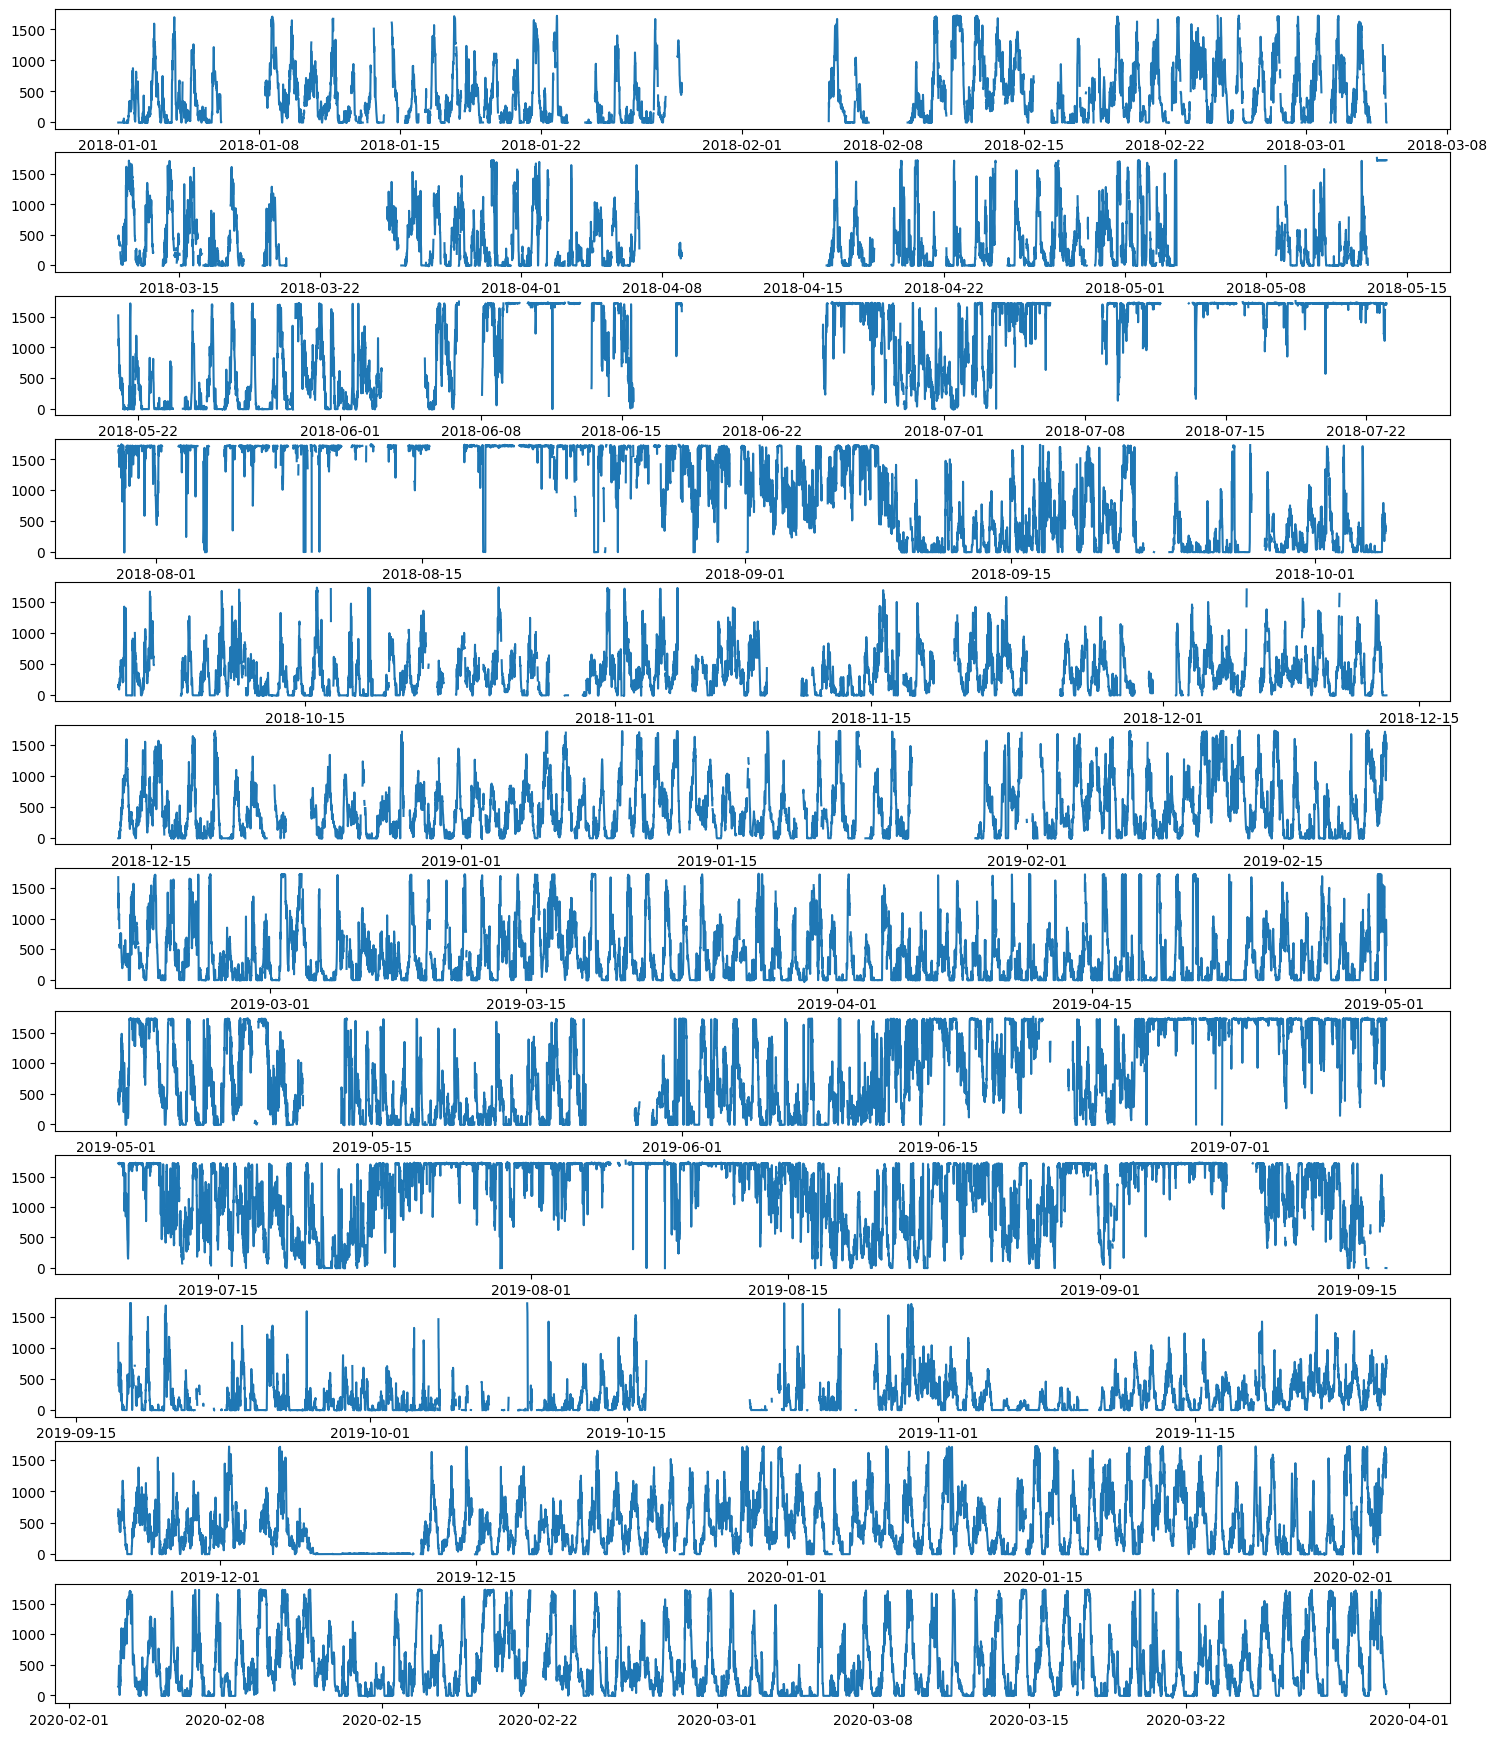

In [8]:
fig, ax = plt.subplots(12, 1, figsize=(18,22))
for i in range(12):
    ax[i].plot(df.ActivePower[i*10000:(i+1)*10000])
plt.show()

In [9]:
df.index

DatetimeIndex(['2017-12-31 00:00:00+00:00', '2017-12-31 00:10:00+00:00',
               '2017-12-31 00:20:00+00:00', '2017-12-31 00:30:00+00:00',
               '2017-12-31 00:40:00+00:00', '2017-12-31 00:50:00+00:00',
               '2017-12-31 01:00:00+00:00', '2017-12-31 01:10:00+00:00',
               '2017-12-31 01:20:00+00:00', '2017-12-31 01:30:00+00:00',
               ...
               '2020-03-30 22:20:00+00:00', '2020-03-30 22:30:00+00:00',
               '2020-03-30 22:40:00+00:00', '2020-03-30 22:50:00+00:00',
               '2020-03-30 23:00:00+00:00', '2020-03-30 23:10:00+00:00',
               '2020-03-30 23:20:00+00:00', '2020-03-30 23:30:00+00:00',
               '2020-03-30 23:40:00+00:00', '2020-03-30 23:50:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Timestamp', length=118224, freq=None)

In [10]:
# check the missing data gap distribution
active_power_notnull = df.dropna(subset=["ActivePower"])
deltas = active_power_notnull.reset_index().Timestamp.diff()[1:]

gaps = deltas[deltas > timedelta(minutes = 10)]

In [11]:
# Maximum continuous gap is a little over a week - between 50 and 70% of the gaps are only 1 sample (20 min gap)
gaps.describe()

count                         1666
mean     0 days 02:30:02.160864345
std      0 days 12:25:21.862308057
min                0 days 00:20:00
25%                0 days 00:20:00
50%                0 days 00:20:00
75%                0 days 00:40:00
max                7 days 04:30:00
Name: Timestamp, dtype: object

Checking the distribution of ActivePower values, we see that it has a strongly bimodal distribution with most values being close to zero or close to the maximum.

Whether the maximum values were clipped or a byproduct of some constraint (e.g. max power output of windmill), it means we don't need to be concerned about outliers.

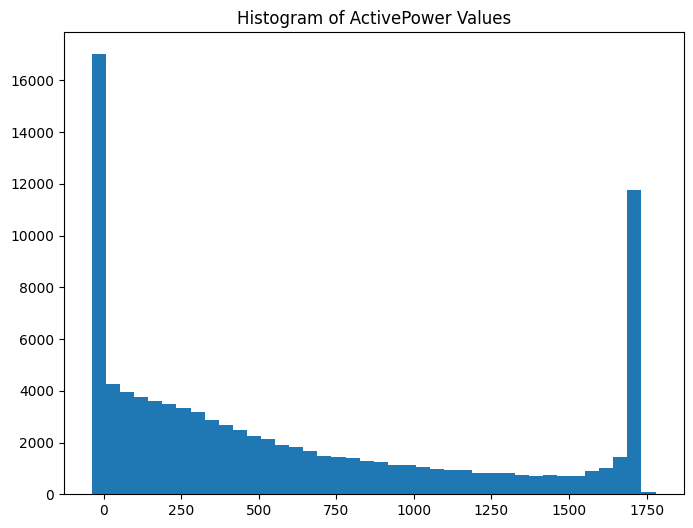

In [12]:
plt.figure(figsize=(8,6))
plt.hist(df.ActivePower, bins=40)
plt.title('Histogram of ActivePower Values')
plt.show()

# Correlations

From looking at variable correlations we identify the following:
- ControlBoxTemperature is empty
- Blade2PitchAngle is equivalent to Blade3PitchAngle
- NacellePosition is equivalent to WindDirection
- WTG is a single-value categorical variable (hence not included in correlation)
- GeneratorRPM and RotorRPM are nearly perfectly correlated
- GeneratorWindingTemperature 1 and 2 are nearly perfectly correlated

We can remove the above variables (or one of the pair in case of near or perfect correlation) in data preprocessing because they won't contribute any information to predicting ActivePower. In fact it's better if we drop them for storage, training speed, and model interpretibility.

In [13]:
df.corr()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
ActivePower,1.000000,-0.065637,0.655400,-0.368997,-0.367978,-0.367978,NaN,0.818850,0.821921,0.849604,0.931390,0.932521,0.347363,0.101627,0.028108,0.719092,0.849069,-0.000135,0.028108,0.940390
AmbientTemperatue,-0.065637,1.000000,0.246505,0.085461,0.090904,0.090904,NaN,0.017216,0.162511,-0.130123,0.077859,0.078736,0.589729,0.836539,-0.037498,-0.020313,-0.129290,-0.005511,-0.037498,-0.095308
BearingShaftTemperature,0.655400,0.246505,1.000000,-0.475557,-0.466856,-0.466856,NaN,0.883344,0.772887,0.640947,0.765115,0.763926,0.809116,0.542104,0.183929,0.594546,0.640584,-0.000990,0.183929,0.596201
Blade1PitchAngle,-0.368997,0.085461,-0.475557,1.000000,0.997774,0.997774,NaN,-0.599178,-0.557949,-0.757056,-0.376102,-0.372369,-0.198583,0.194911,-0.058300,-0.381478,-0.757147,-0.000534,-0.058300,-0.403092
Blade2PitchAngle,-0.367978,0.090904,-0.466856,0.997774,1.000000,1.000000,NaN,-0.592103,-0.549792,-0.754325,-0.371057,-0.367451,-0.190296,0.190562,-0.057624,-0.379541,-0.754539,-0.000636,-0.057624,-0.402786
Blade3PitchAngle,-0.367978,0.090904,-0.466856,0.997774,1.000000,1.000000,NaN,-0.592103,-0.549792,-0.754325,-0.371057,-0.367451,-0.190296,0.190562,-0.057624,-0.379541,-0.754539,-0.000636,-0.057624,-0.402786
ControlBoxTemperature,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GearboxBearingTemperature,0.818850,0.017216,0.883344,-0.599178,-0.592103,-0.592103,NaN,1.000000,0.906020,0.850209,0.853024,0.851923,0.596065,0.307694,0.214486,0.751875,0.850795,-0.002314,0.214486,0.800433
GearboxOilTemperature,0.821921,0.162511,0.772887,-0.557949,-0.549792,-0.549792,NaN,0.906020,1.000000,0.806972,0.899693,0.898335,0.506648,0.190350,0.277619,0.770088,0.807776,-0.004536,0.277619,0.793140
GeneratorRPM,0.849604,-0.130123,0.640947,-0.757056,-0.754325,-0.754325,NaN,0.850209,0.806972,1.000000,0.796434,0.795223,0.303804,-0.052185,0.176964,0.768065,0.999723,0.001133,0.176964,0.854787


In [14]:
# confirm that ControlBoxTemperature is empty
df.ControlBoxTemperature.value_counts()

0.0    62160
Name: ControlBoxTemperature, dtype: int64

In [15]:
# Blade2PitchAngle and Blade3PitchAngle are identical
df.Blade2PitchAngle.equals(df.Blade3PitchAngle)

True

In [16]:
# NacellePosition and WindDirection are identical
df.NacellePosition.equals(df.WindDirection)

True

In [17]:
df.WTG.value_counts()

G01    118224
Name: WTG, dtype: int64

### Options for Missing Values

We could do the following:
- Remove samples with missing values
- Fill in the missing values with stationary value (e.g. average)
- Fill in the missing values with interpolated value
- Fill in the missing values with estimated values from e.g. a sinusoid or SARIMA model

As a first pass we'll 

In [18]:
# remove samples with missing target values
df_nonull_active_power = df[df.ActivePower.notnull()]

In [19]:
df_linear_interp = df.interpolate(method="linear")

# Stationarity and Autocorrelation

### Daily/Weekly/Yearly

In [20]:
hourly = df['ActivePower'].groupby(lambda x: x.hour).agg([np.mean, np.std])

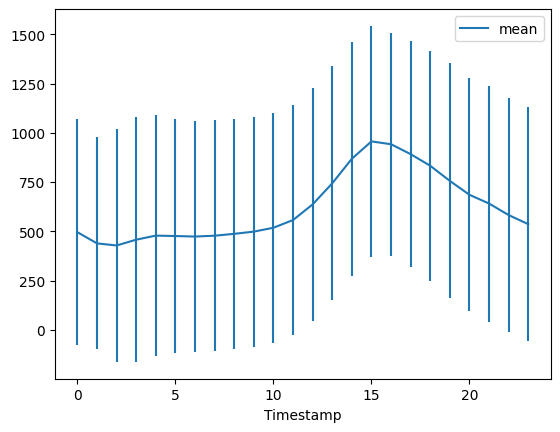

In [21]:
hourly.plot(y='mean', yerr='std')
plt.show()

In [22]:
weekly = df['ActivePower'].groupby(lambda x: x.dayofweek).agg([np.mean, np.std])

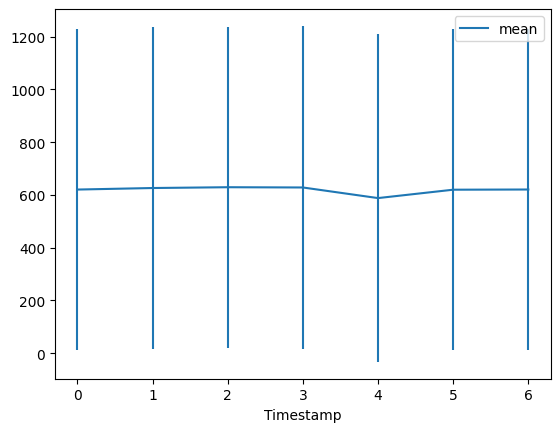

In [23]:
weekly.plot(y='mean', yerr='std')
plt.show()

In [24]:
yearly = df['ActivePower'].groupby(lambda x: x.month).agg([np.mean, np.std])

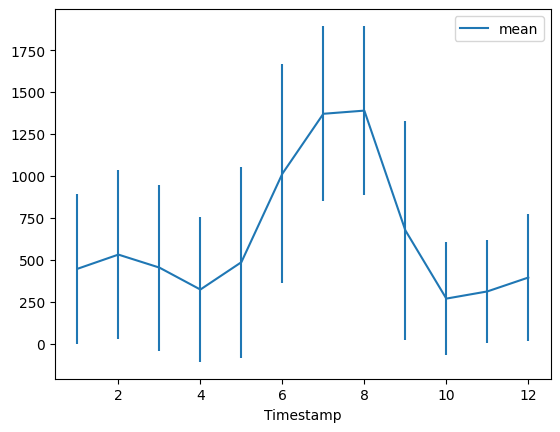

In [25]:
yearly.plot(y='mean', yerr='std')
plt.show()

In [26]:
df.columns

Index(['ActivePower', 'AmbientTemperatue', 'BearingShaftTemperature',
       'Blade1PitchAngle', 'Blade2PitchAngle', 'Blade3PitchAngle',
       'ControlBoxTemperature', 'GearboxBearingTemperature',
       'GearboxOilTemperature', 'GeneratorRPM', 'GeneratorWinding1Temperature',
       'GeneratorWinding2Temperature', 'HubTemperature', 'MainBoxTemperature',
       'NacellePosition', 'ReactivePower', 'RotorRPM', 'TurbineStatus', 'WTG',
       'WindDirection', 'WindSpeed'],
      dtype='object')

In [27]:
# out of curiosity, is it hottest in the same months?
yearly_temp = df['AmbientTemperatue'].groupby(lambda x: x.month).agg([np.mean, np.std])

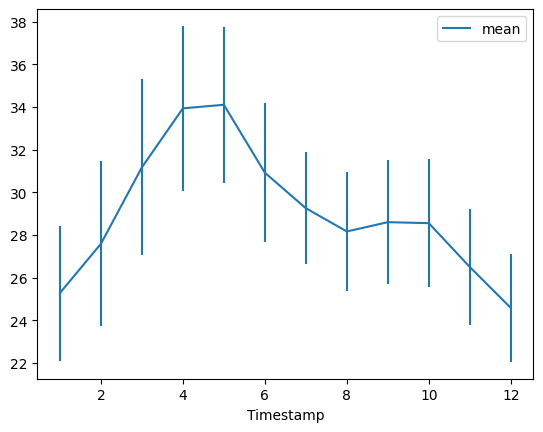

In [28]:
# nope, looks like it's hottest in the spring.
yearly_temp.plot(y='mean', yerr='std')
plt.show()

### Unit Root Test

In [29]:
# to do this test we need no missing values. First take the linear interpolation between values
# and drop the first NANs.
first_nonull_idx = df[df.ActivePower.notnull()].iloc[0].name
linear_interp_series = df.ActivePower.interpolate().loc[first_nonull_idx:]
stationarity_res = adfuller(linear_interp_series)

In [30]:
# reject the null hypothesis with strong significance - time series has no unit root
p_value = stationarity_res[1]
print(p_value)

3.962471023548903e-30


### Lag Plots and Autocorrelation

In the plots below we see values of the time series plotted against itself with lags of 1, 2, and 3 samples. The linear-like structure shows promise for using an autoregressive model component. In other words, it looks likely we can use recent value in the time series to predict future values.

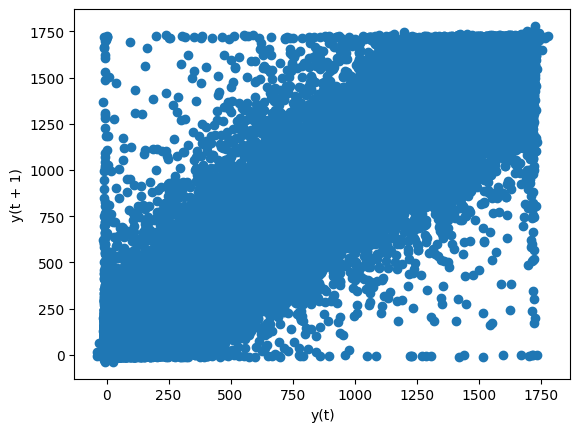

In [31]:
plt.figure()
pd.plotting.lag_plot(df.ActivePower)
plt.show()

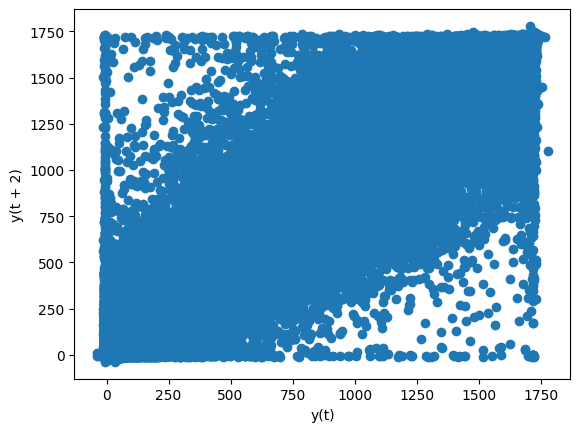

In [32]:
plt.figure()
pd.plotting.lag_plot(df.ActivePower, lag=2)
plt.show()

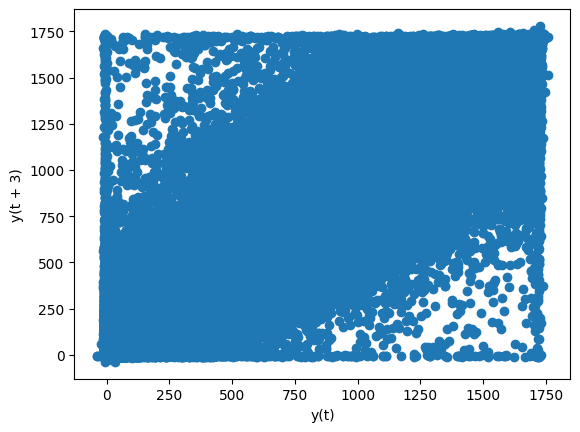

In [33]:
plt.figure()
pd.plotting.lag_plot(df.ActivePower, lag=3)
plt.show()

The plots below shows the autocorrelation for the whole series. There's an interesting peak around sample 50000. Given that there are ~52000 samples in a year, this is likely from the yearly seasonality noticed earlier.

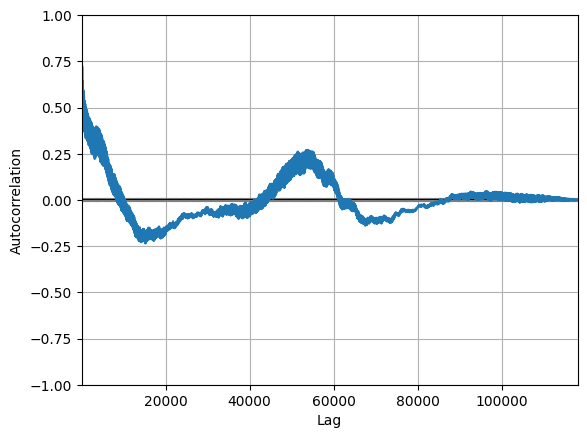

In [34]:
plt.figure()
pd.plotting.autocorrelation_plot(linear_interp_series)
plt.show()

Looking at the autocorrelation at a lower level, we see other peaks at increments of about 144, which matches up with the daily seasonality.

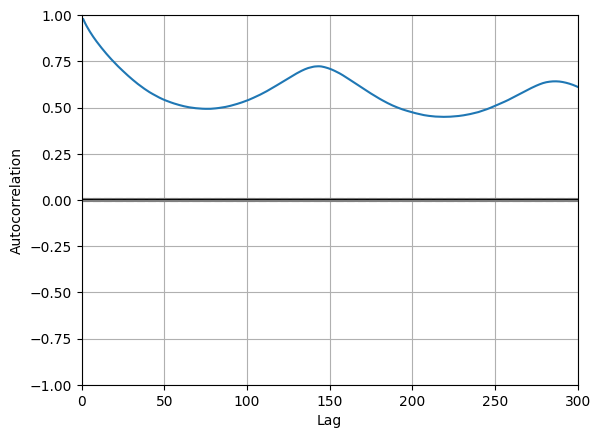

In [35]:
plt.figure()
ax = pd.plotting.autocorrelation_plot(linear_interp_series)
ax.set_xlim([0,300])
plt.show()

The partial autocorrelation shown below shows the strength of relationship between lagged series, except where the influence of previous lags has been removed. 

Interestingly, the PACF drops dramatically after a single lag, suggesting that the most recent observation contains most of the predictive power, e.g. an AR model of 1 may be well suited.

/Users/karmen/Projects/wind-power-forecast/.venv_temp/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


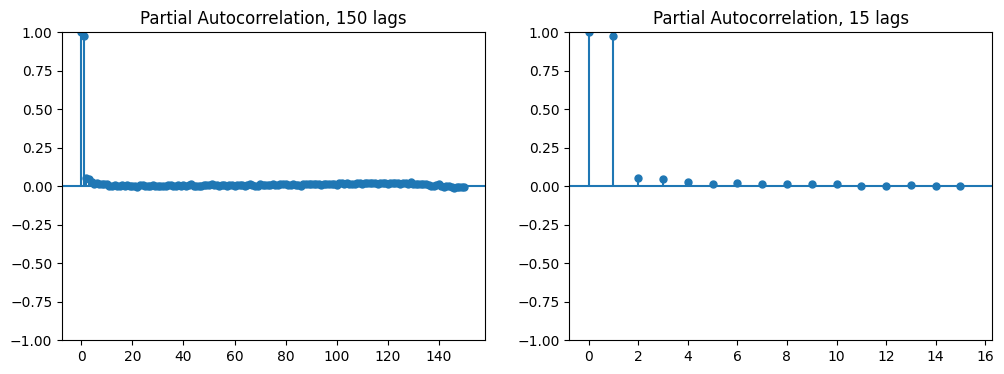

In [36]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
plot_pacf(linear_interp_series, lags=150, ax=ax[0], title='Partial Autocorrelation, 150 lags')
plot_pacf(linear_interp_series, lags=15, ax=ax[1], title='Partial Autocorrelation, 15 lags')
plt.show()